In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mrmustard.lab import Circuit, SqueezedVacuum, Number
from mrmustard.lab.transformations import BSgate
from mrmustard.physics.wigner import wigner_discretized

In [6]:
def generate_wigner_sample(
    r_vals,              # list or array: [r0, r1, r2]
    thetas,              # list or array: [theta1, theta2, theta3]
    phis,                # list or array: [phi1, phi2, phi3]
    photon_numbers,      # list or array: [n0, n1]
    grid_size=1023,
    x_max=4.0,
    plot=False
):
    """
    Generate a discretized Wigner function for a single parameter set.

    Returns
    -------
    wigner_grid : np.ndarray of shape (grid_size, grid_size)
        Discretized Wigner function evaluated on a square phase-space grid.
    """

    # --- Input squeezed states ---
    input_state = [
        SqueezedVacuum(
            i,
            r_vals[i],
            phi=(0 if i % 2 == 1 else np.pi / 2)
        )
        for i in range(3)
    ]

    # --- Interferometer ---
    BS1 = BSgate([0, 1], thetas[0], phis[0])
    BS2 = BSgate([1, 2], thetas[1], phis[1])
    BS3 = BSgate([0, 1], thetas[2], phis[2])
    interferometer = BS1 >> BS2 >> BS3

    # --- Post-selection measurements ---
    measurement = [
        Number(i, photon_numbers[i]).dual for i in range(2)
    ]

    # --- Build and contract circuit ---
    c = Circuit(input_state) >> interferometer >> Circuit(measurement)
    out = c.contract().normalize()

    # --- Phase-space grid ---
    xvec = np.linspace(-x_max, x_max, grid_size)
    pvec = np.linspace(-x_max, x_max, grid_size)

    # --- Wigner function ---
    wigner, _, _ = wigner_discretized(
        out.dm().ansatz.array,
        xvec,
        pvec
    )

    # --- Optional plot ---
    if plot:
        plt.figure(figsize=(5, 4))
        plt.imshow(
            wigner.T,
            origin="lower",
            extent=[-x_max, x_max, -x_max, x_max],
            cmap="RdBu",
            vmin=-1 / np.pi,
            vmax=1 / np.pi
        )
        plt.colorbar(label="Wigner function")
        plt.xlabel("x")
        plt.ylabel("p")
        plt.title("Conditional Wigner function")
        plt.tight_layout()
        plt.show()

    return wigner

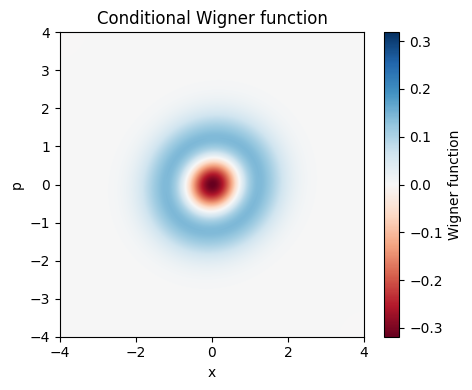

In [8]:
r_vals = [0.5, 0.1, 0.2]
thetas = [np.pi/2, np.pi/6, np.pi/3]
phis   = [0.0, np.pi/2, np.pi]
photon_numbers = [1, 0]

wigner = generate_wigner_sample(
    r_vals,
    thetas,
    phis,
    photon_numbers,
    plot=True
)